# Ejercisios Practicos IA

Imports Ej 6 práctico 1

In [1]:

import random
import math
from deap import base, creator, tools, algorithms

Ejercicio 6 Práctica 1

In [2]:
CANT_CIUDADES = 20
random.seed(42)

# Generamos coordenadas aleatorias para las ciudades
CIUDADES = [(random.randint(0, 100), random.randint(0, 100)) for _ in range(CANT_CIUDADES)]

# Matriz de distancias
MATRIZ_DISTANCIAS = {}
for i in range(CANT_CIUDADES):
    MATRIZ_DISTANCIAS[i] = {}
    for j in range(CANT_CIUDADES):
        MATRIZ_DISTANCIAS[i][j] = math.dist(CIUDADES[i], CIUDADES[j])

# Matriz de tiempos
MATRIZ_TIEMPOS = {}
for i in range(CANT_CIUDADES):
    MATRIZ_TIEMPOS[i] = {}
    for j in range(CANT_CIUDADES):
        if i == j:
            MATRIZ_TIEMPOS[i][j] = 0
        else:
            trafico = random.uniform(0.8, 2.5)
            MATRIZ_TIEMPOS[i][j] = MATRIZ_DISTANCIAS[i][j] * trafico


# Como el problema tiene distancia y tiempo como objectivos
# le damos dos pesos negativos (minimización en ambos).
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individuo", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

# Un individuo es una permutación de todas las ciudades
toolbox.register("indices_ciudades", random.sample, range(CANT_CIUDADES), CANT_CIUDADES)
toolbox.register("individuo", tools.initIterate, creator.Individuo, toolbox.indices_ciudades)
toolbox.register("poblacion", tools.initRepeat, list, toolbox.individuo)


def evaluar_ruta_multi(individuo):
    dist_total = 0
    tiempo_total = 0

    ciudad_actual = individuo[0]
    for siguiente in individuo[1:]:
        dist_total += MATRIZ_DISTANCIAS[ciudad_actual][siguiente]
        tiempo_total += MATRIZ_TIEMPOS[ciudad_actual][siguiente]
        ciudad_actual = siguiente

    # Cerramos el ciclo volviendo a la primera ciudad
    dist_total += MATRIZ_DISTANCIAS[ciudad_actual][individuo[0]]
    tiempo_total += MATRIZ_TIEMPOS[ciudad_actual][individuo[0]]

    return dist_total, tiempo_total


toolbox.register("evaluate", evaluar_ruta_multi)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selNSGA2)  # selección multiobjetivo (NSGA-II)


def ejecutar_moga_tsp():
    print("\n Problema del Agente Viajero con MOGA\n ")

    TAM_POBLACION = 300
    PROB_CRUCE = 0.7
    PROB_MUTACION = 0.2
    MAX_GENERACIONES = 250

    poblacion = toolbox.poblacion(n=TAM_POBLACION)
    frente_pareto = tools.ParetoFront()

    # Estadísticas separadas para distancia y tiempo
    stats_dist = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats_dist.register("avg", lambda x: sum(x) / len(x))
    stats_dist.register("min", min)

    stats_tiempo = tools.Statistics(lambda ind: ind.fitness.values[1])
    stats_tiempo.register("avg", lambda x: sum(x) / len(x))
    stats_tiempo.register("min", min)

    stats = tools.MultiStatistics(distancia=stats_dist, tiempo=stats_tiempo)

    poblacion, log = algorithms.eaMuPlusLambda(
        poblacion, toolbox,
        mu=TAM_POBLACION, lambda_=TAM_POBLACION,
        cxpb=PROB_CRUCE, mutpb=PROB_MUTACION,
        ngen=MAX_GENERACIONES,
        stats=stats, halloffame=frente_pareto, verbose=True
    )

    print("\n--- Evolución completada ---")
    print(f"Se encontraron {len(frente_pareto)} soluciones no dominadas (frente de Pareto):")
    print("(Distancia, Tiempo)")

    for ind in frente_pareto:
        d, t = ind.fitness.values
        print(f"  {d:.2f}, {t:.2f}")

    print("\nPrimera solución del frente (la más corta en distancia):")
    d, t = frente_pareto[0].fitness.values
    print(f"  Ruta: {frente_pareto[0]}")
    print(f"  Distancia total: {d:.2f}")
    print(f"  Tiempo total: {t:.2f}")


# Ejecutamos la función para que corra en el notebook
ejecutar_moga_tsp()


 Problema del Agente Viajero con MOGA
 
   	      	          distancia           	            tiempo            
   	      	------------------------------	------------------------------
gen	nevals	avg    	gen	min    	nevals	avg    	gen	min    	nevals
0  	300   	1153.77	0  	872.573	300   	1912.17	0  	1351.95	300   
1  	280   	1085.28	1  	872.573	280   	1762.78	1  	1327.6 	280   
2  	262   	1048.54	2  	872.573	262   	1684.35	2  	1321.23	262   
3  	277   	1020.76	3  	836.122	277   	1609.36	3  	1282.41	277   
4  	270   	985.93 	4  	810.264	270   	1545.48	4  	1245.82	270   
5  	267   	963.644	5  	810.264	267   	1509.46	5  	1245.82	267   
6  	265   	943.952	6  	800.07 	265   	1472.93	6  	1245.82	265   
7  	265   	930.27 	7  	792.916	265   	1445.71	7  	1220.04	265   
8  	274   	916.292	8  	740.079	274   	1415.74	8  	1155.48	274   
9  	275   	898.44 	9  	740.079	275   	1393.82	9  	1096.99	275   
10 	267   	888.411	10 	719.43 	267   	1370.5 	10 	1078.74	267   
11 	270   	881.573	11 	719.43 	27

Imports Ej 4 práctico 2

In [3]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from pandas.plotting import scatter_matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Ejercicio 4 práctica 2, auto-mpg dataset

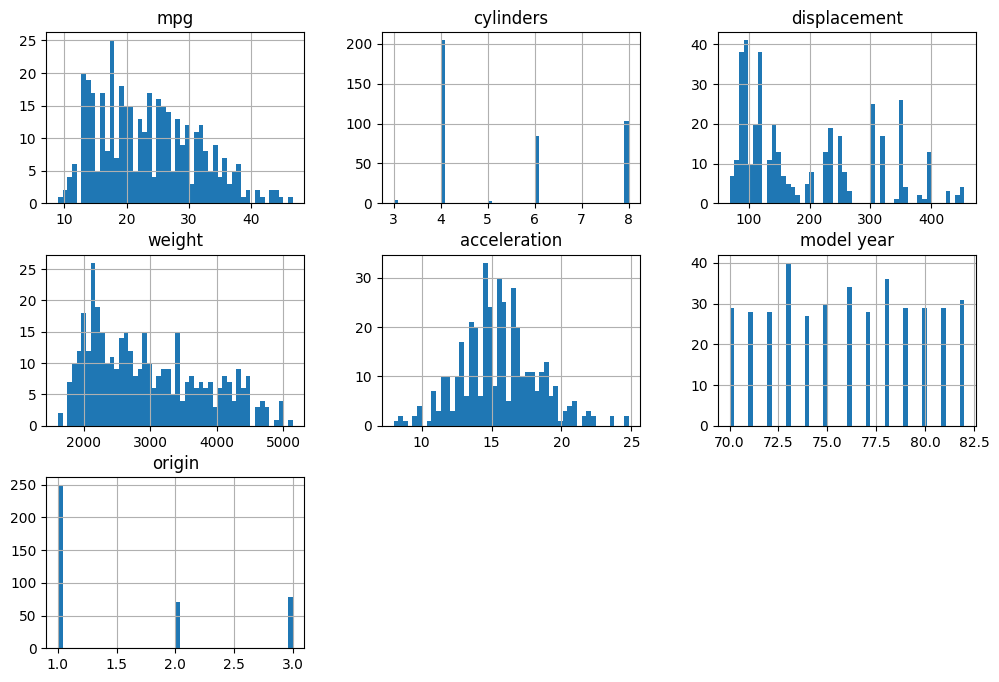

    mpg  cylinders  displacement horsepower  weight  acceleration  model year  \
0  18.0          8         307.0        130    3504          12.0          70   
1  15.0          8         350.0        165    3693          11.5          70   
2  18.0          8         318.0        150    3436          11.0          70   
3  16.0          8         304.0        150    3433          12.0          70   
4  17.0          8         302.0        140    3449          10.5          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino  
Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Nul

C:\Users\frana\AppData\Local\Temp\ipykernel_5592\1764316167.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  carsConsume["horsepower"].replace("?", np.nan, inplace=True)


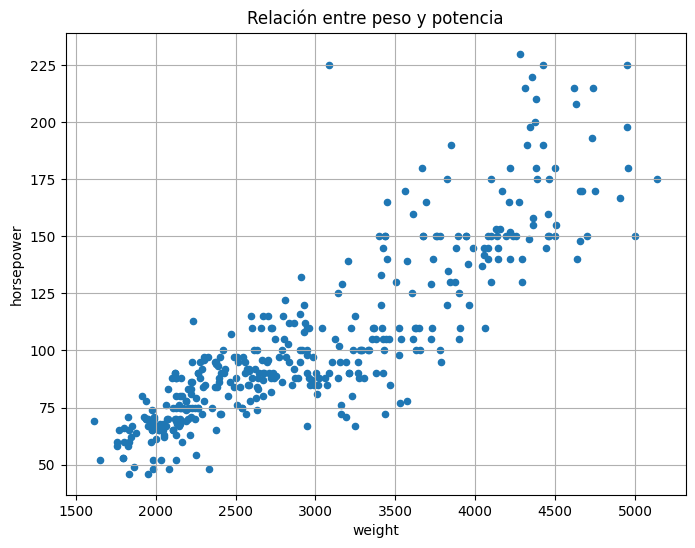

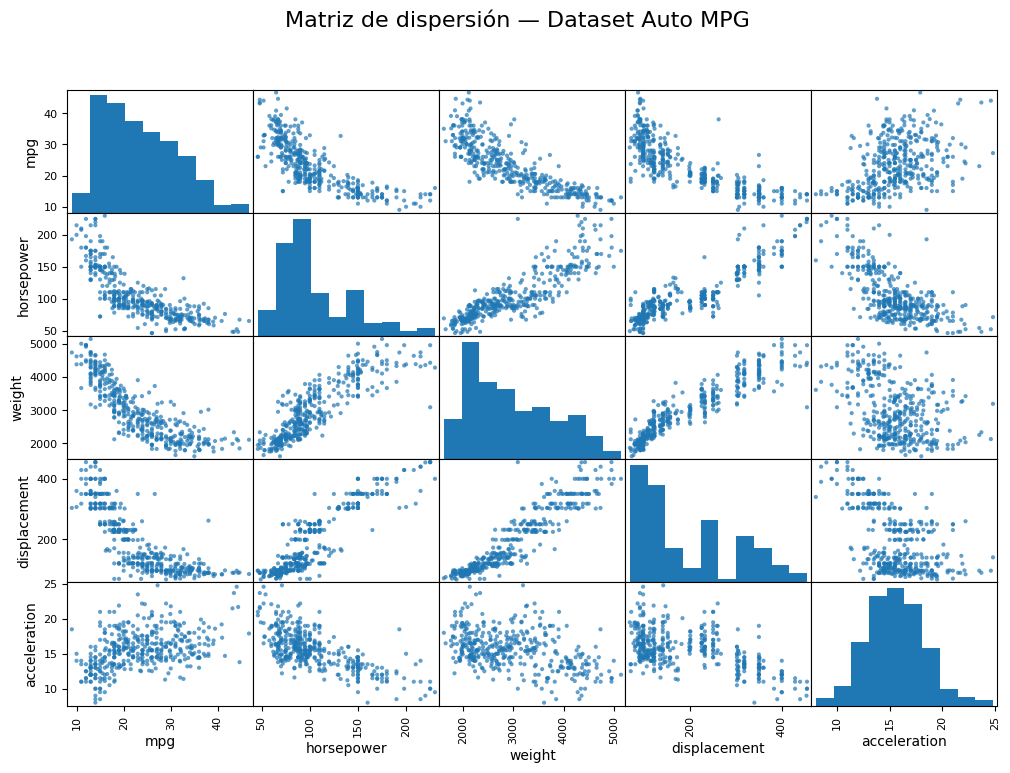

mpg                        1.000000
acceleration_per_hp        0.710556
model year                 0.579267
origin                     0.563450
acceleration               0.420289
power_weight_ratio        -0.269699
displacement_per_weight   -0.714536
cylinders                 -0.775396
horsepower                -0.778427
displacement              -0.804203
weight                    -0.831741
Name: mpg, dtype: float64
Shape del dataset procesado: (398, 9)
R²: 0.833
RMSE: 3.39
Primeras 5 predicciones: [19.8 21.3 34.  25.6 16.3]
Valores reales: [15.  18.  40.9 24.  17. ]
Linear Regression RMSE: 3.3934450645142156


C:\Users\frana\AppData\Local\Temp\ipykernel_5592\1764316167.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  carsConsume["horsepower"].fillna(median_hp, inplace=True)


In [4]:
carsConsume = pd.read_csv(Path("Datasets/auto-mpg[1].csv"))
carsConsume.hist(bins=50, figsize=(12,8))
plt.show()
print(carsConsume.head())
print(carsConsume.columns)

# Reemplazar "?" por NaN y convertir horsepower a numérico
carsConsume["horsepower"].replace("?", np.nan, inplace=True)
carsConsume["horsepower"] = carsConsume["horsepower"].astype(float)

print(carsConsume.info())

y = carsConsume["mpg"]
X = carsConsume.drop(columns=["mpg", "car name"], errors='ignore')

train_carsConsume, test_carsConsume = train_test_split(carsConsume,test_size=0.2, stratify=carsConsume["cylinders"], random_state=42)

X_train = train_carsConsume.drop(columns=["mpg", "car name"], errors='ignore')
y_train = train_carsConsume["mpg"]

X_test = test_carsConsume.drop(columns=["mpg", "car name"], errors='ignore')
y_test = test_carsConsume["mpg"]

carsConsume.plot(kind="scatter", x="weight", y="horsepower", grid=True, figsize=(8, 6))
plt.title("Relación entre peso y potencia")
plt.show()

attributes = ["mpg", "horsepower", "weight", "displacement", "acceleration"]
scatter_matrix(carsConsume[attributes], figsize=(12, 8), alpha=0.7, diagonal='hist')
plt.suptitle("Matriz de dispersión — Dataset Auto MPG", fontsize=16)
plt.show()

# Relación potencia/peso — eficiencia del motor
carsConsume["power_weight_ratio"] = carsConsume["horsepower"] / carsConsume["weight"]

# Relación cilindrada/peso — mide "grandeza del motor relativo al tamaño del auto"
carsConsume["displacement_per_weight"] = carsConsume["displacement"] / carsConsume["weight"]

# Relación aceleración/potencia — qué tan rápido acelera por caballo de fuerza
carsConsume["acceleration_per_hp"] = carsConsume["acceleration"] / carsConsume["horsepower"]

corr_matrix = carsConsume.corr(numeric_only=True)

# Ordenar correlaciones con respecto a 'mpg'
print(corr_matrix["mpg"].sort_values(ascending=False))

median_hp = carsConsume["horsepower"].median()
carsConsume["horsepower"].fillna(median_hp, inplace=True)

num_attribs = ["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year"]
cat_attribs = ["origin"]

num_pipeline = make_pipeline(SimpleImputer(strategy="median"),StandardScaler())

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([("num", num_pipeline, num_attribs),("cat", cat_pipeline, cat_attribs)])

set_config(display='diagram')  # Muestra el pipeline visualmente
carsConsume_prepared = preprocessing.fit_transform(carsConsume)

print("Shape del dataset procesado:", carsConsume_prepared.shape)

X_train_prepared = preprocessing.fit_transform(X_train)
X_test_prepared = preprocessing.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)
y_pred = lin_reg.predict(X_test_prepared)

print(f"R²: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

carsConsume_predictions = lin_reg.predict(X_test_prepared)
print("Primeras 5 predicciones:", carsConsume_predictions[:5].round(1))
print("Valores reales:", y_test.iloc[:5].values)

lin_mse = mean_squared_error(y_test, carsConsume_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Linear Regression RMSE:", lin_rmse)

Imports Ej 6 Práctica 3

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Ejercicio 6 Práctica 3 - Clasificación Multiclase (Cervezas)

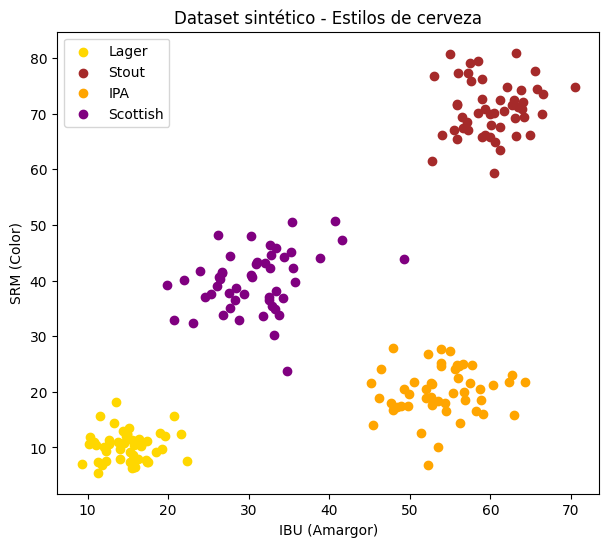

One vs Rest (OVR) 
              precision    recall  f1-score   support

       Lager       1.00      1.00      1.00        15
       Stout       1.00      1.00      1.00        15
         IPA       0.94      1.00      0.97        15
    Scottish       1.00      0.93      0.97        15

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



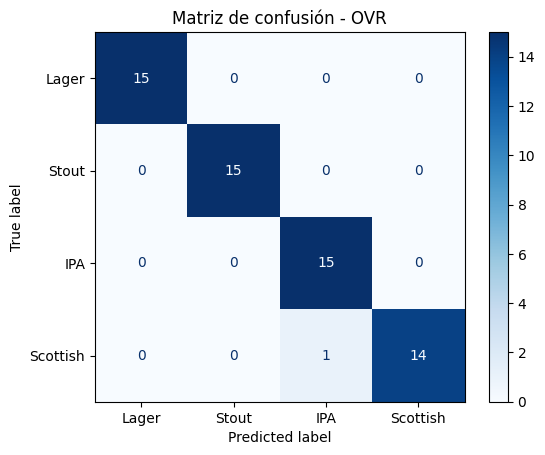

One vs One (OVO)
              precision    recall  f1-score   support

       Lager       1.00      1.00      1.00        15
       Stout       1.00      1.00      1.00        15
         IPA       1.00      1.00      1.00        15
    Scottish       1.00      1.00      1.00        15

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



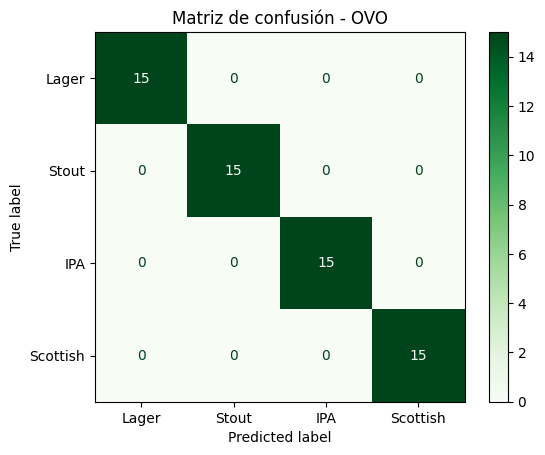

c:\Users\frana\.conda\envs\IA\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 Softmax multinomial 
              precision    recall  f1-score   support

       Lager       1.00      1.00      1.00        15
       Stout       1.00      1.00      1.00        15
         IPA       1.00      1.00      1.00        15
    Scottish       1.00      1.00      1.00        15

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



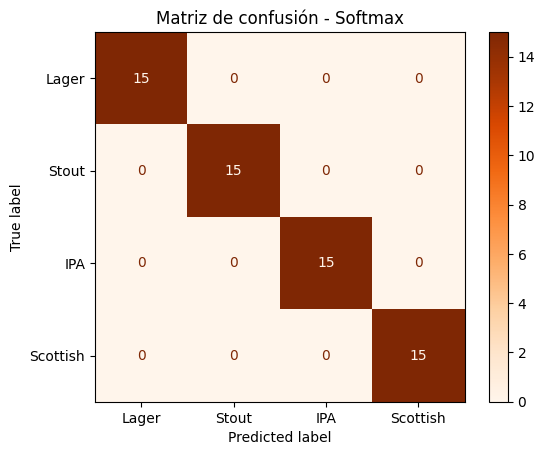


Comparación de hiperparámetros (Softmax multinomial) 
C=0.1  -> Precisión de validación: 1.000
C=1    -> Precisión de validación: 1.000
C=10   -> Precisión de validación: 1.000


c:\Users\frana\.conda\envs\IA\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\frana\.conda\envs\IA\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\frana\.conda\envs\IA\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


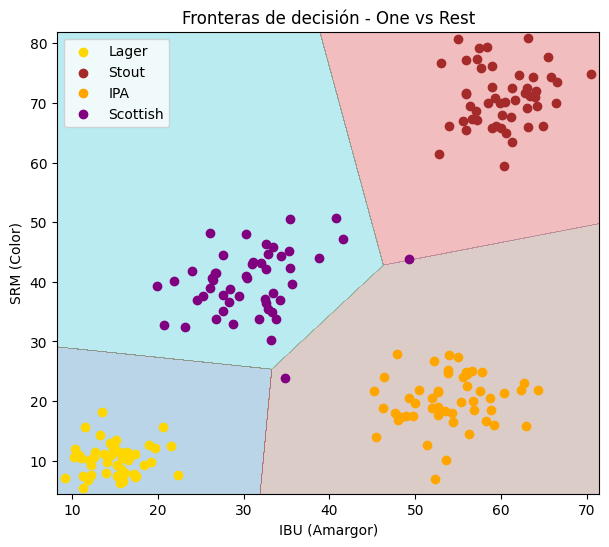

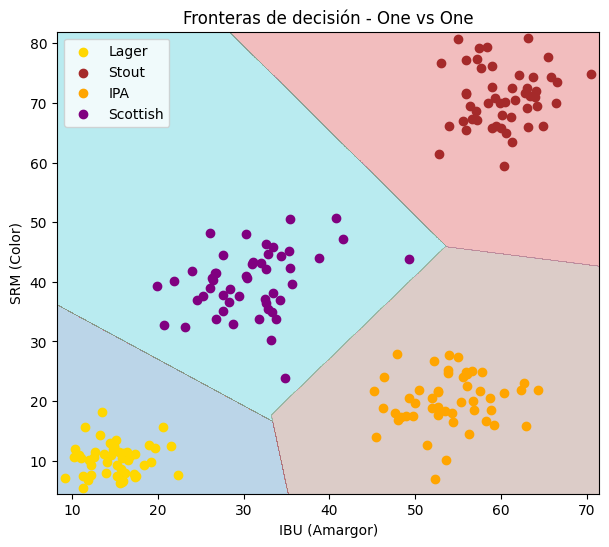

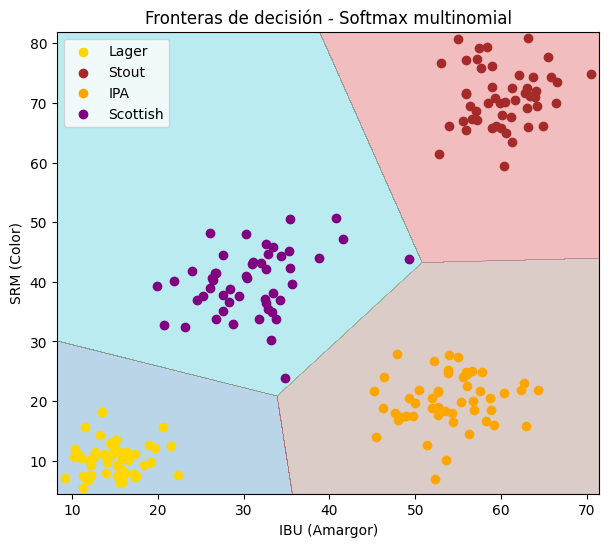

In [7]:
np.random.seed(42)

# Cada fila: [IBU, SRM]
n = 50
ipa = np.column_stack((np.random.normal(55, 5, n), np.random.normal(20, 5, n)))      # Clara pero amarga
lager = np.column_stack((np.random.normal(15, 3, n), np.random.normal(10, 3, n)))      # Clara y poco amarga
scottish = np.column_stack((np.random.normal(30, 5, n), np.random.normal(40, 5, n)))    # Oscura pero moderada
stout = np.column_stack((np.random.normal(60, 5, n), np.random.normal(70, 5, n)))      # Muy oscura y amarga

X = np.vstack((lager, stout, ipa, scottish))
y = np.array([0]*n + [1]*n + [2]*n + [3]*n)

clases = ['Lager', 'Stout', 'IPA', 'Scottish']

# dividimos entre entrenamiento y validacion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Escalado de características
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Dataset original
plt.figure(figsize=(7,6))
colores = ['gold', 'brown', 'orange', 'purple']
for i, c in zip(range(4), colores):
    plt.scatter(X[y==i, 0], X[y==i, 1], label=clases[i], color=c)
plt.xlabel("IBU (Amargor)")
plt.ylabel("SRM (Color)")
plt.title("Dataset sintético - Estilos de cerveza")
plt.legend()
plt.show()

# CLASIFICADORES MULTICLASE

# One vs Rest 
modelo_ovr = OneVsRestClassifier(LogisticRegression(max_iter=500))
modelo_ovr.fit(X_train_std, y_train)
pred_ovr = modelo_ovr.predict(X_test_std)

print("One vs Rest (OVR) ")
print(classification_report(y_test, pred_ovr, target_names=clases))
ConfusionMatrixDisplay(confusion_matrix(y_test, pred_ovr), display_labels=clases).plot(cmap='Blues')
plt.title("Matriz de confusión - OVR")
plt.show()

# One vs One
modelo_ovo = OneVsOneClassifier(LogisticRegression(max_iter=500))
modelo_ovo.fit(X_train_std, y_train)
pred_ovo = modelo_ovo.predict(X_test_std)

print("One vs One (OVO)")
print(classification_report(y_test, pred_ovo, target_names=clases))
ConfusionMatrixDisplay(confusion_matrix(y_test, pred_ovo), display_labels=clases).plot(cmap='Greens')
plt.title("Matriz de confusión - OVO")
plt.show()

# Softmax multinomial 
modelo_softmax = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
modelo_softmax.fit(X_train_std, y_train)
pred_softmax = modelo_softmax.predict(X_test_std)

print(" Softmax multinomial ")
print(classification_report(y_test, pred_softmax, target_names=clases))
ConfusionMatrixDisplay(confusion_matrix(y_test, pred_softmax), display_labels=clases).plot(cmap='Oranges')
plt.title("Matriz de confusión - Softmax")
plt.show()

# Comparacion de hiperparametros
print("\nComparación de hiperparámetros (Softmax multinomial) ")
for c in [0.1, 1, 10]:
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, C=c)
    model.fit(X_train_std, y_train)
    score = model.score(X_test_std, y_test)
    print(f"C={c:<4} -> Precisión de validación: {score:.3f}")

# Fronteras de decision
def mostrar_fronteras(modelo, X, y, titulo):
    paso = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, paso),
                         np.arange(y_min, y_max, paso))
    Z = modelo.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.tab10)
    for i, c in zip(range(4), colores):
        plt.scatter(X[y==i, 0], X[y==i, 1], label=clases[i], color=c)
    plt.xlabel("IBU (Amargor)")
    plt.ylabel("SRM (Color)")
    plt.title(titulo)
    plt.legend()
    plt.show()

# Fronteras de decisión para cada modelo
mostrar_fronteras(modelo_ovr, X, y, "Fronteras de decisión - One vs Rest")
mostrar_fronteras(modelo_ovo, X, y, "Fronteras de decisión - One vs One")
mostrar_fronteras(modelo_softmax, X, y, "Fronteras de decisión - Softmax multinomial")

Imports Ej 7 práctica 4

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    ConfusionMatrixDisplay, f1_score, precision_score, recall_score
)
from sklearn.preprocessing import OneHotEncoder

Ej 7 Práctica 4

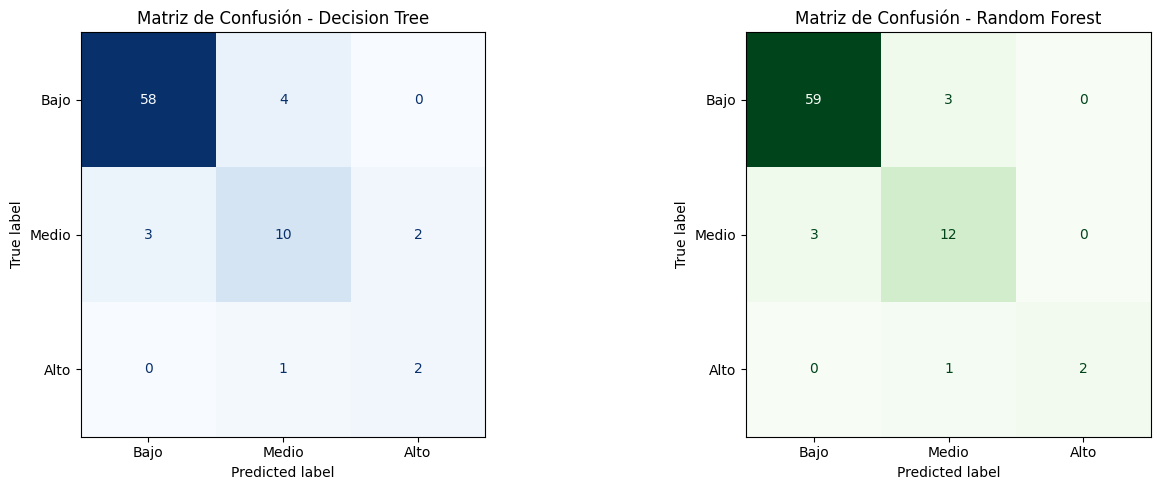

=== Métricas de Clasificación ===

Decision Tree:
  Accuracy: 0.8750
  F1-score: 0.8773
  Precision: 0.8806
  Recall: 0.8750

Random Forest:
  Accuracy: 0.9125
  F1-score: 0.9127
  Precision: 0.9156
  Recall: 0.9125


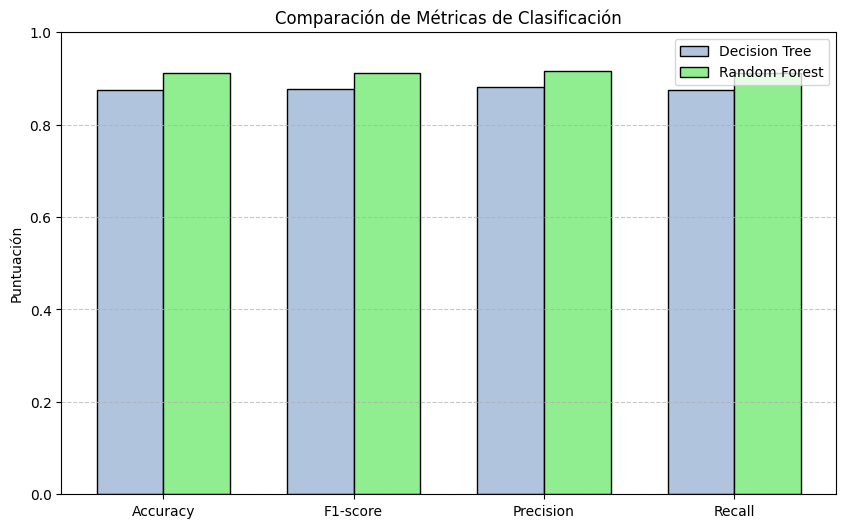

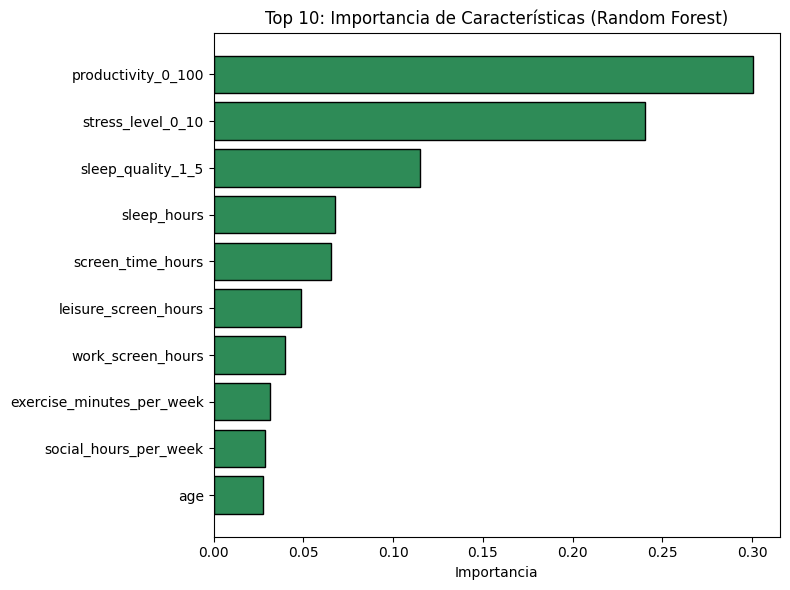

In [13]:
ST_vs_MW = pd.read_csv('Datasets/ScreenTime vs MentalWellness.csv')

def categorize_wellness(score):
    if score <= 33:
        return 'Bajo'
    elif score <= 66:
        return 'Medio'
    else:
        return 'Alto'

ST_vs_MW['wellness_class'] = ST_vs_MW['mental_wellness_index_0_100'].apply(categorize_wellness)

ST_vs_MW = ST_vs_MW.drop(columns=['user_id', 'mental_wellness_index_0_100'])

categorical_cols = ['gender', 'occupation', 'work_mode']
numerical_cols = [col for col in ST_vs_MW.columns if col not in categorical_cols + ['wellness_class']]

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = encoder.fit_transform(ST_vs_MW[categorical_cols])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_cols))

X = pd.concat([ST_vs_MW[numerical_cols].reset_index(drop=True), encoded_df], axis=1)
y = ST_vs_MW['wellness_class'].astype(str).values  # Asegura tipo string

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Training
ST_vs_MW_DT = DecisionTreeClassifier(random_state=42, max_depth=10)
ST_vs_MW_DT.fit(X_train, y_train)

ST_vs_MW_RF = RandomForestClassifier(n_estimators=100, random_state=42)
ST_vs_MW_RF.fit(X_train, y_train)

# Predicts
y_pred_dt = ST_vs_MW_DT.predict(X_test)
y_pred_rf = ST_vs_MW_RF.predict(X_test)

# Matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt, labels=['Bajo', 'Medio', 'Alto'])
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['Bajo', 'Medio', 'Alto'])
disp_dt.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Matriz de Confusión - Decision Tree')

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=['Bajo', 'Medio', 'Alto'])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Bajo', 'Medio', 'Alto'])
disp_rf.plot(ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title('Matriz de Confusión - Random Forest')

plt.tight_layout()
plt.show()

# Métricas numéricas
print("=== Métricas de Clasificación ===")
for name, y_pred in [("Decision Tree", y_pred_dt), ("Random Forest", y_pred_rf)]:
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    print(f"\n{name}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")

# Comparación de métricas
metrics = ['Accuracy', 'F1-score', 'Precision', 'Recall']
dt_vals = [
    accuracy_score(y_test, y_pred_dt),
    f1_score(y_test, y_pred_dt, average='weighted'),
    precision_score(y_test, y_pred_dt, average='weighted'),
    recall_score(y_test, y_pred_dt, average='weighted')
]
rf_vals = [
    accuracy_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_rf, average='weighted'),
    precision_score(y_test, y_pred_rf, average='weighted'),
    recall_score(y_test, y_pred_rf, average='weighted')
]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, dt_vals, width, label='Decision Tree', color='lightsteelblue', edgecolor='black')
plt.bar(x + width/2, rf_vals, width, label='Random Forest', color='lightgreen', edgecolor='black')
plt.xticks(x, metrics)
plt.ylabel('Puntuación')
plt.title('Comparación de Métricas de Clasificación')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Importancia de características (solo Random Forest)
importances = ST_vs_MW_RF.feature_importances_
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(8, 6))
plt.barh(range(10), importances[indices], color='seagreen', edgecolor='black')
plt.yticks(range(10), [X.columns[i] for i in indices])
plt.gca().invert_yaxis()
plt.title('Top 10: Importancia de Características (Random Forest)')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

Imports Ej 9 Práctica 4

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Ejercicio 9 Práctica 4 - Stacking Classifier (Iris)


Meta-modelo: Regresión logística 
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



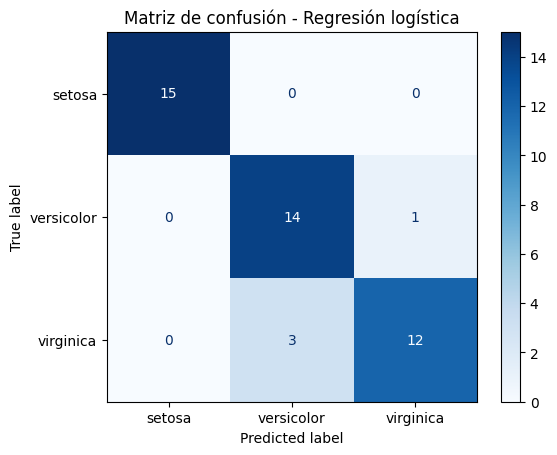


Meta-modelo: SVM 
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



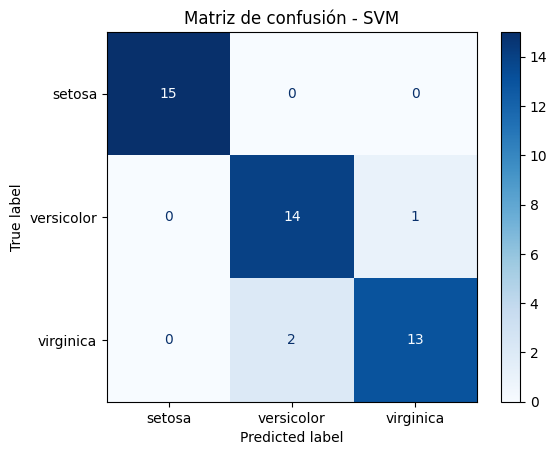


Meta-modelo: Árbol de decisión 
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.75      1.00      0.86        15
   virginica       1.00      0.67      0.80        15

    accuracy                           0.89        45
   macro avg       0.92      0.89      0.89        45
weighted avg       0.92      0.89      0.89        45



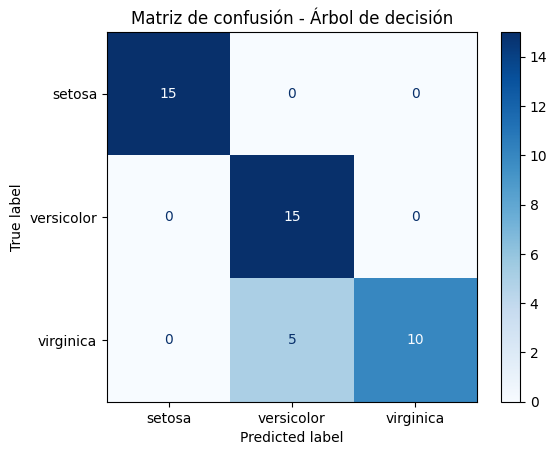

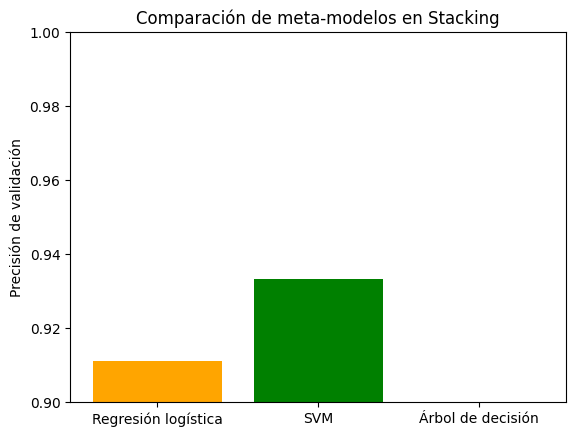

In [17]:
# Cargar dataset Iris
data = load_iris()
X, y = data.data, data.target
labels = data.target_names

# Dividir entre entrenamiento y validación 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Escalar características 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelos base 
base_models = [
    ('dt', DecisionTreeClassifier(max_depth=4, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('logreg', LogisticRegression(max_iter=500))
]

# Distintos meta-modelos para probar mejoras 
meta_models = {
    'Regresión logística': LogisticRegression(max_iter=500),
    'SVM': SVC(kernel='linear', probability=True),
    'Árbol de decisión': DecisionTreeClassifier(max_depth=3, random_state=42)
}

# Entrenar y evaluar los modelos de Stacking 
for name, meta_model in meta_models.items():
    print(f"\nMeta-modelo: {name} ")
    stack = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model,
        passthrough=True
    )
    stack.fit(X_train_scaled, y_train)
    y_pred = stack.predict(X_test_scaled)

    print(classification_report(y_test, y_pred, target_names=labels))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=labels).plot(cmap='Blues')
    plt.title(f"Matriz de confusión - {name}")
    plt.show()

# Comparación visual de precisión
scores = []
for name, meta_model in meta_models.items():
    stack = StackingClassifier(estimators=base_models, final_estimator=meta_model, passthrough=True)
    stack.fit(X_train_scaled, y_train)
    acc = stack.score(X_test_scaled, y_test)
    scores.append((name, acc))

names, accs = zip(*scores)
plt.bar(names, accs, color=['orange', 'green', 'blue'])
plt.ylabel("Precisión de validación")
plt.title("Comparación de meta-modelos en Stacking")
plt.ylim(0.9, 1.0)
plt.show()

Imports Ej 3 Práctica 5

In [19]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Ej 3 Práctica 5

RESULTADOS 

MLP: 0.911
SVM: 0.933
Decision Tree: 0.889 

CLASIFICACIÓN (MLP)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.82      0.93      0.88        15
   virginica       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



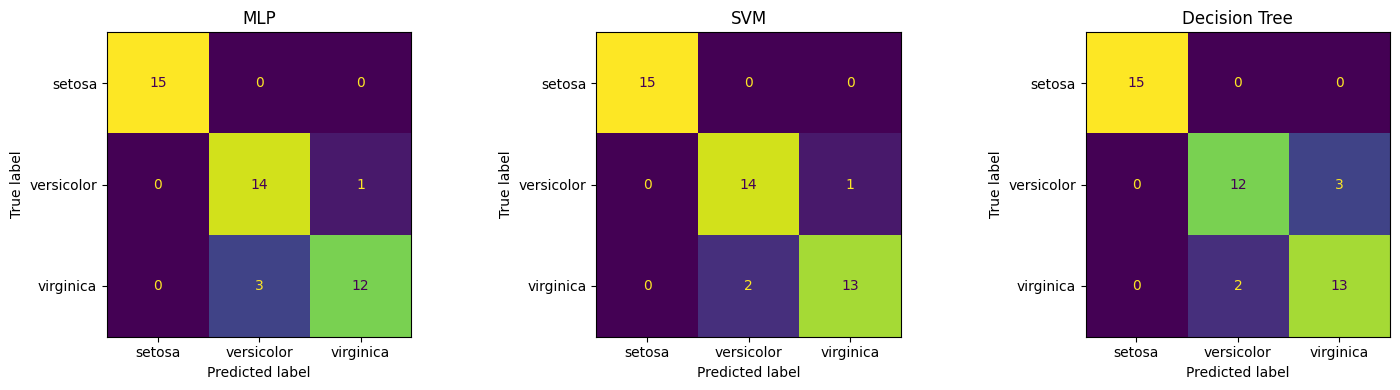

In [20]:
# Dataset
iris = load_iris()
X, y = iris.data, iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Escalado de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(10, 10), activation='relu', solver='adam', max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)

# SVM
svm = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)
svm.fit(X_train_scaled, y_train)

# Árbol de decisión
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

# Predicción
y_pred_mlp = mlp.predict(X_test_scaled)
y_pred_svm = svm.predict(X_test_scaled)
y_pred_tree = tree.predict(X_test)

# Evaluación
print("RESULTADOS \n")
print("MLP:", round(accuracy_score(y_test, y_pred_mlp), 3))
print("SVM:", round(accuracy_score(y_test, y_pred_svm), 3))
print("Decision Tree:", round(accuracy_score(y_test, y_pred_tree), 3), "\n")

print("CLASIFICACIÓN (MLP)\n")
print(classification_report(y_test, y_pred_mlp, target_names=target_names))

# Matriz de confusión con Matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
models = {
    "MLP": y_pred_mlp,
    "SVM": y_pred_svm,
    "Decision Tree": y_pred_tree
}

for ax, (name, y_pred) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(name)

plt.tight_layout()
plt.show()

Imports Ej 3 Práctica 6

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Imports para contraste
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

Ejercicio 3 Práctica 6 - CNN (Iris) y Comparación


=== Modelo: 1 conv, 16 dense ===


c:\Users\frana\.conda\envs\IA\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Precisión en test: 0.8889
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


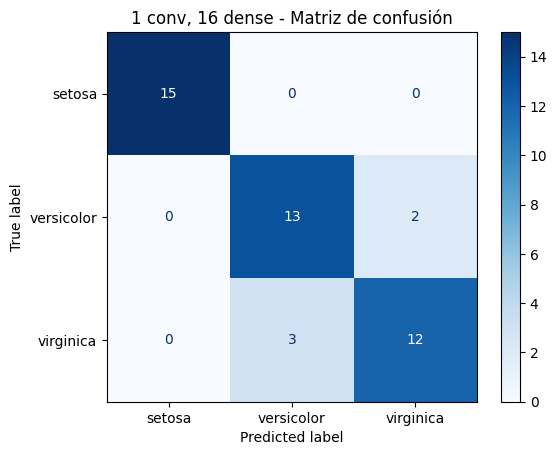


=== Modelo: 2 conv, 32 dense ===


c:\Users\frana\.conda\envs\IA\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Precisión en test: 0.9333
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


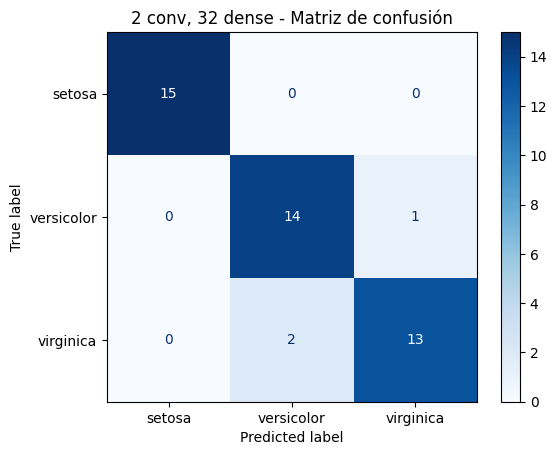


=== Modelo: 2 conv, 64 dense ===


c:\Users\frana\.conda\envs\IA\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Precisión en test: 0.9333
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


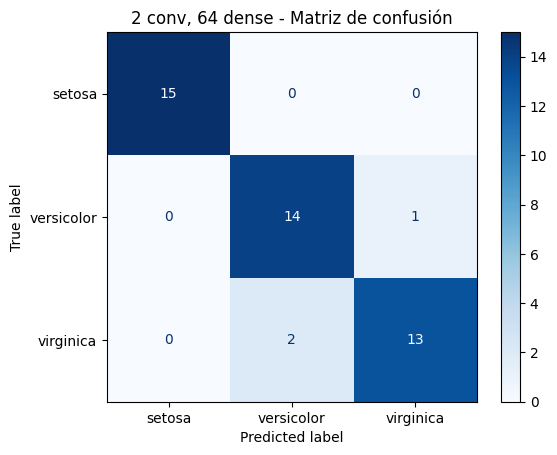

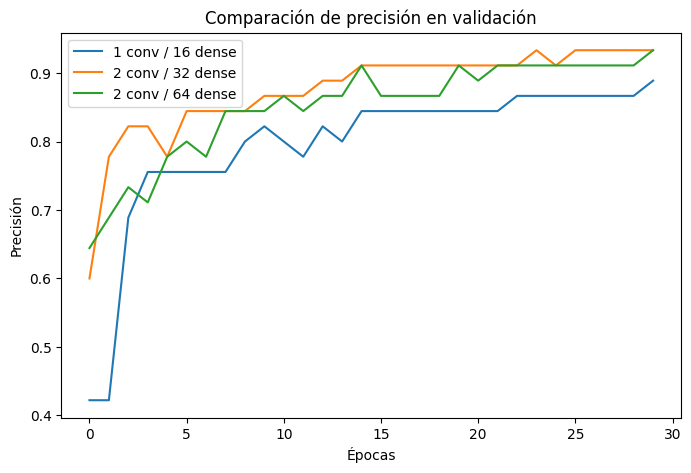


 Resumen de configuraciones CNN 
1 conv / 16 dense -> Precisión: 0.889
2 conv / 32 dense -> Precisión: 0.933
2 conv / 64 dense -> Precisión: 0.933

--- Contraste con modelos previos (cálculo real) ---
 - Árbol de Decisión: 0.8889
 - KNN: 0.9111
 - Regresión Logística: 0.9111
 - Stacking (mejor caso): 0.9333
 - CNN (mejor configuración actual): 0.9333


c:\Users\frana\.conda\envs\IA\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [26]:
# Cargar dataset 
iris = load_iris()
X, y = iris.data, iris.target
labels = iris.target_names

# Escalado y división
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# NOTA: Para el contraste, el Árbol de Decisión usará X_train/X_test no escalados.
# Creamos esas variables aquí para tenerlas disponibles.
X_train_no_scaled, X_test_no_scaled, y_train_no_scaled, y_test_no_scaled = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


# Adaptar datos a formato CNN (2D)
# CNN espera datos con forma (samples, height, width, channels)
# Convertimos cada muestra (4 características) a una "imagen" de 2x2 con 1 canal.
X_train_cnn = X_train.reshape(-1, 2, 2, 1)
X_test_cnn = X_test.reshape(-1, 2, 2, 1)

# One-hot encoding de etiquetas
y_train_cat = keras.utils.to_categorical(y_train)
y_test_cat = keras.utils.to_categorical(y_test)

# Función para crear distintos modelos CNN
def create_cnn_model(conv_layers=1, dense_units=32):
    model = models.Sequential()
    
    # Añadimos padding='SAME' para asegurar que la dimensión no se reduzca a 0
    # al apilar capas.
    model.add(layers.Conv2D(8, (2, 2), activation='relu', padding='SAME', input_shape=(2, 2, 1)))
    
    # Agregar más capas convolucionales según configuración
    for _ in range(conv_layers - 1):
        # También añadimos padding='SAME'
        model.add(layers.Conv2D(8, (2, 2), activation='relu', padding='SAME'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Distintas configuraciones a probar 
configs = [
    {"conv_layers": 1, "dense_units": 16},
    {"conv_layers": 2, "dense_units": 32},
    {"conv_layers": 2, "dense_units": 64},
]

results = []

# Entrenamiento y evaluación
for cfg in configs:
    print(f"\n=== Modelo: {cfg['conv_layers']} conv, {cfg['dense_units']} dense ===")
    model = create_cnn_model(cfg["conv_layers"], cfg["dense_units"])
    
    history = model.fit(
        X_train_cnn, y_train_cat,
        validation_data=(X_test_cnn, y_test_cat),
        epochs=30,
        batch_size=8,
        verbose=0
    )
    
    test_loss, test_acc = model.evaluate(X_test_cnn, y_test_cat, verbose=0)
    print(f"Precisión en test: {test_acc:.4f}")
    
    y_pred = np.argmax(model.predict(X_test_cnn), axis=1)
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=labels).plot(cmap='Blues')
    plt.title(f"{cfg['conv_layers']} conv, {cfg['dense_units']} dense - Matriz de confusión")
    plt.show()
    
    results.append({
        "conv_layers": cfg["conv_layers"],
        "dense_units": cfg["dense_units"],
        "accuracy": test_acc,
        "history": history
    })

# Comparación de resultados
plt.figure(figsize=(8,5))
for res in results:
    plt.plot(res["history"].history['val_accuracy'], label=f"{res['conv_layers']} conv / {res['dense_units']} dense")
plt.title("Comparación de precisión en validación")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.show()

print("\n Resumen de configuraciones CNN ")
for res in results:
    print(f"{res['conv_layers']} conv / {res['dense_units']} dense -> Precisión: {res['accuracy']:.3f}")

# Contraste con modelos previos 
print("\n--- Contraste con modelos previos (cálculo real) ---")

# Árbol de Decisión (como en Práctica 5)
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train_no_scaled, y_train_no_scaled) # Usa datos no escalados
y_pred_tree = tree.predict(X_test_no_scaled)
acc_tree = accuracy_score(y_test, y_pred_tree)
print(f" - Árbol de Decisión: {acc_tree:.4f}")

# KNN (K-Nearest Neighbors)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train) # X_train está escalado
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print(f" - KNN: {acc_knn:.4f}")

# 3. Regresión Logística (Softmax)
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_logreg = log_reg.predict(X_test)
acc_logreg = accuracy_score(y_test, y_pred_logreg)
print(f" - Regresión Logística: {acc_logreg:.4f}")

# 4. Stacking (como en Práctica 4, Ej 9)
base_models_stack = [
    ('dt', DecisionTreeClassifier(max_depth=4, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('logreg', LogisticRegression(max_iter=500, random_state=42))
]

stack = StackingClassifier(
    estimators=base_models_stack,
    final_estimator=LogisticRegression(max_iter=500),
    passthrough=True
)
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)
acc_stack = accuracy_score(y_test, y_pred_stack)
print(f" - Stacking (mejor caso): {acc_stack:.4f}")

# 5. CNN
best_cnn_acc = max(r['accuracy'] for r in results)
print(f" - CNN (mejor configuración actual): {best_cnn_acc:.4f}")

Imports Ej 4 Práctica 7

In [11]:
import numpy as np

Ej 4 Práctica 7

In [21]:
data = open('Datasets/poems.txt', 'r').read()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

# hyperparameters
hidden_size = 100
seq_length = 25
learning_rate = 1e-1

# model parameters for GRU
# update gate
Wz = np.random.randn(hidden_size, vocab_size) * 0.01
Uz = np.random.randn(hidden_size, hidden_size) * 0.01
bz = np.zeros((hidden_size, 1))
# reset gate
Wr = np.random.randn(hidden_size, vocab_size) * 0.01
Ur = np.random.randn(hidden_size, hidden_size) * 0.01
br = np.zeros((hidden_size, 1))
# candidate hidden state
Wh = np.random.randn(hidden_size, vocab_size) * 0.01
Uh = np.random.randn(hidden_size, hidden_size) * 0.01
bh = np.zeros((hidden_size, 1))
# output layer
Why = np.random.randn(vocab_size, hidden_size) * 0.01
by = np.zeros((vocab_size, 1))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lossFun(inputs, targets, hprev):
    """
    inputs, targets: listas de índices de caracteres
    hprev: estado oculto inicial (Hx1)
    Devuelve: loss, gradientes y último hidden state
    """
    xs, hs, zs, rs, h_tilde, ys, ps = {}, {}, {}, {}, {}, {}, {}
    hs[-1] = np.copy(hprev)
    loss = 0

    # ---------- FORWARD ----------
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size, 1))
        xs[t][inputs[t]] = 1

        # GRU equations
        zs[t] = sigmoid(np.dot(Wz, xs[t]) + np.dot(Uz, hs[t - 1]) + bz)
        rs[t] = sigmoid(np.dot(Wr, xs[t]) + np.dot(Ur, hs[t - 1]) + br)
        h_tilde[t] = np.tanh(np.dot(Wh, xs[t]) + np.dot(Uh, rs[t] * hs[t - 1]) + bh)
        hs[t] = (1 - zs[t]) * hs[t - 1] + zs[t] * h_tilde[t]

        # output layer
        ys[t] = np.dot(Why, hs[t]) + by
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))
        loss += -np.log(ps[t][targets[t], 0])

    # ---------- BACKWARD ----------
    dWz, dUz, dbz = np.zeros_like(Wz), np.zeros_like(Uz), np.zeros_like(bz)
    dWr, dUr, dbr = np.zeros_like(Wr), np.zeros_like(Ur), np.zeros_like(br)
    dWh, dUh, dbh = np.zeros_like(Wh), np.zeros_like(Uh), np.zeros_like(bh)
    dWhy, dby = np.zeros_like(Why), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])

    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1
        dWhy += np.dot(dy, hs[t].T)
        dby += dy

        dh = np.dot(Why.T, dy) + dhnext
        dz = (h_tilde[t] - hs[t - 1]) * dh
        dz *= zs[t] * (1 - zs[t])

        dh_tilde = zs[t] * dh
        dh_tilde_raw = (1 - h_tilde[t] * h_tilde[t]) * dh_tilde

        dr = np.dot(Uh.T, dh_tilde_raw) * hs[t - 1]
        dr *= rs[t] * (1 - rs[t])

        dWz += np.dot(dz, xs[t].T)
        dUz += np.dot(dz, hs[t - 1].T)
        dbz += dz

        dWr += np.dot(dr, xs[t].T)
        dUr += np.dot(dr, hs[t - 1].T)
        dbr += dr

        dWh += np.dot(dh_tilde_raw, xs[t].T)
        dUh += np.dot(dh_tilde_raw, (rs[t] * hs[t - 1]).T)
        dbh += dh_tilde_raw

        dhprev = (1 - zs[t]) * dh + np.dot(Uz.T, dz)
        dhprev += np.dot(Ur.T, dr)
        dhprev += rs[t] * np.dot(Uh.T, dh_tilde_raw)
        dhnext = dhprev

    for dparam in [dWz, dUz, dWr, dUr, dWh, dUh, dWhy, dbz, dbr, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)

    return loss, dWz, dUz, dWr, dUr, dWh, dUh, dWhy, dbz, dbr, dbh, dby, hs[len(inputs) - 1]

def sample(h, seed_ix, n):
    """Genera texto a partir del modelo GRU entrenado."""
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    for t in range(n):
        z = sigmoid(np.dot(Wz, x) + np.dot(Uz, h) + bz)
        r = sigmoid(np.dot(Wr, x) + np.dot(Ur, h) + br)
        h_tilde = np.tanh(np.dot(Wh, x) + np.dot(Uh, r * h) + bh)
        h = (1 - z) * h + z * h_tilde
        y = np.dot(Why, h) + by
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

# ---------- ENTRENAMIENTO ----------
n, p = 0, 0
# Adagrad memories
mems = [np.zeros_like(param) for param in [Wz, Uz, Wr, Ur, Wh, Uh, Why, bz, br, bh, by]]
smooth_loss = -np.log(1.0 / vocab_size) * seq_length

while True:
    if p + seq_length + 1 >= len(data) or n == 0:
        hprev = np.zeros((hidden_size, 1))
        p = 0
    inputs = [char_to_ix[ch] for ch in data[p:p + seq_length]]
    targets = [char_to_ix[ch] for ch in data[p + 1:p + seq_length + 1]]

    if n % 100 == 0:
        sample_ix = sample(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt,))

    loss, *grads, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 100 == 0:
        print(f'iter {n}, loss: {smooth_loss:.4f}')

    # Adagrad update
    params = [Wz, Uz, Wr, Ur, Wh, Uh, Why, bz, br, bh, by]
    for i, (param, dparam) in enumerate(zip(params, grads)):
        mems[i] += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mems[i] + 1e-8)

    p += seq_length
    n += 1


data has 1158 characters, 45 unique.
----
 qUMiíygUCPtqvl n,YO.cqCdy fúplñLvn
ubdcóSiLEpUu jclóyUn
LESdá,nrúruñPcid
nOCLoónf.ñqEhfUinóúyLhñmrxaiíeoEs
tvCú jmYómRyEtRáéCzLsiymúúuitCvttPrSEgEelfu. Uza
MzEPófECs,ARoótjíóaúíl.o
zE.éóímíRzYjSxzprC
 
----
iter 0, loss: 95.1666
----
   f oleo rrana e  ori.
umpoe baa ereEr, uuuarenurbf eaiigabo ora.ele em .apfa aempacfi ca
vEr mtprecanctran n eel c
uaecrinlahdl ers  lneipleu atioeeua risomle C o eu u icencpeaer.bads ts 
preaA Prd m 
----
iter 100, loss: 94.1523
----
 a
i mechas iEsasenací he ulaenede hemo cunounadusde mes.
EL ilduaor ue puaLssde a lsetardo posche childe lipreecuulsten fumda hi oeabes, cfe salevy suuelsomesmefze denpapmi dvil aróm oreosico.o
l ces  
----
iter 200, loss: 91.1281
----
 zrsen ú susnta.
La mu.
Lnaila lil mer con chl ueln, mres.
L  alú de qui denmaimene fui mi cuill ll fund di md suzno g
f  uns sechemado fulimada llepam.
La fue met lpcide.
xLainlrosáp.ro  siue lesda.
L 
----
iter 300, loss: 87.6290
----
  me meceno 

KeyboardInterrupt: 